# WIP Development of MPChecker: 002
 - 20190315
 - MJP
 - Initial look at MPChecker-like functionality 
 - Just testing-out the steps that would be required 

In [1]:
%load_ext autoreload
%matplotlib inline

# Standard imports 
import numpy as np 
import matplotlib.pyplot as plt 
import healpy as hp
import sys, os

import MPC_library as MPCL
import phys_const as PHYS
import mpchecker 
import classes as Classes
import params 
import angles as ANG 


/Users/matthewjohnpayne/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/matthewjohnpayne/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Some of the results returned below will depend on the assumed HP scale for the preprocessing
 - E.g. the HP # for the center of the pointing ...
 - At the time of evaluation the assumed parameters are ...

In [2]:
print("Healpix: Nside", params.hp_nside)
print("Healpix: Npix", params.hp_npix)
print("Healpix: Area [deg^2]", params.hp_area)
print("Healpix: Side [deg]", params.hp_side)

Healpix: Nside 256
Healpix: Npix 786432
Healpix: Area [deg^2] 0.05245585282569793
Healpix: Side [deg] 0.22903242745449373


# Set up a list of "fake" pointings for PanSTARRS (F51) 
 - These are all on the same night, and this night is the night of one of the nbody epochs, so no significant propogation is involved

In [3]:
# Overall / average quantities 
obsCode   = 'G96'
JDutc_INT = 2458360
FOV = 3.0 ## <<-- Assuming all pointings correspond to exposures with diameter = 3.0 degrees

# Generate ~100 randomly selected pointings 
Np = 1500 
rInt = np.random.choice(params.hp_npix, size=Np, replace=False)
uv_ = [hp.pix2vec(params.hp_nside, pix, nest=params.hp_nested) for pix in rInt]
HP_ = [hp.vec2pix(params.hp_nside, *UV, nest=params.hp_nested) for UV  in uv_]
'''print("# HP: ", len(HP_), len(list(set(HP_))))
print("Before, HP_ = ", HP_[0])'''
print("Before, uv_ = ", uv_[:3])

# I don't want the pointings to be in the center of each HP
# - Randomly shift by an amount which keeps them within HP
RA_, Dec_ = ANG.unit2radec(uv_)
uv_randomized = []
for i, _ in enumerate(zip(RA_, Dec_ , uv_)):
    condition = True
    while condition:
        # Generating a random shit within the approx scale of a healpix
        dR = (params.hp_side/2.)*np.random.random()
        dD = (params.hp_side/2.)*np.random.random()
        sR = +1 if np.random.random() > 0.5 else -1
        sD = +1 if np.random.random() > 0.5 else -1
        # Shift the RA,Dec
        R = _[0]+sR*dR
        D = _[1]+sD*dD
        # Get the corresponding shifted UV & HP
        UV= ANG.radec2unit(R,D)
        HP= hp.vec2pix(params.hp_nside, *UV, nest=params.hp_nested)
        # Check that the HP is the same as it was initially
        # (I'm just trying to shift the center within the same HP)
        if HP == HP_[i]:
            condition = False 
            uv_randomized.append(UV) 
uv_ = np.array(uv_randomized)
print("After , uv_ = ", uv_[:3])

# Generate multiple different pointings 
PointingList = []
for i in range(Np):
    JDutc = JDutc_INT + 0.25 + 0.5*np.random.rand()
    RA , Dec  = ANG.unit2radec(uv_[i])
    PointingList.append( Classes.Pointing(obsCode, JDutc, RA , Dec, FOV) )

# Examine some of the quantities to check that they are all as expected
print("Number of pointings generated = %d " % len(PointingList) )
print("First pointing: " , PointingList[0])
print("Last  pointing: " , PointingList[-1])
tmpR = [P.RADEC[0] for P in PointingList]
tmpD = [P.RADEC[1] for P in PointingList]
print("RA : min,median,max=",np.min(tmpR), np.median(tmpR), np.max(tmpR))
print("DEC: min,median,max=",np.min(tmpD), np.median(tmpD), np.max(tmpD))

Before, uv_ =  [(0.8597201309930843, 0.42287459090033147, 0.2864583333333333), (-0.20391667280659886, -0.2596643348616897, 0.9439239501953125), (-0.7408202424448915, -0.11686848012950753, -0.6614583333333333)]
After , uv_ =  [[ 0.86022036  0.42196395  0.28629941]
 [-0.20402471 -0.25898382  0.94408755]
 [-0.7408779  -0.1162873  -0.66149619]]
Number of pointings generated = 1500 
First pointing:  G96_2458360.619596065_array([26.12933947])_array([16.6365361])
Last  pointing:  G96_2458360.4636170752_array([228.14391482])_array([-50.46990933])
RA : min,median,max= 0.9742632277712467 176.58492799489954 359.5246864578176
DEC: min,median,max= -86.99066507646809 1.173095135768092 89.28595740566605


# Observatory Positions wrt Center of Ecliptic
 - It will be useful later on to have ensured that each Pointing knows where it was taken from (in heliocentric coords w.r.t. the ecliptic)
 - Use the functionality demonstrated in "Demonstrate_PointingObjects.ipynb"

In [4]:
%%time 
# Do the calculations 
for P in PointingList:
    P.calc_heliocentric_position_of_observatory_in_ecliptic_coords()

# Check the results 
print("Ecliptic Helio coords of Observatory at time of first pointing: " , PointingList[0].helio_ec_posn)
print("Ecliptic Helio coords of Observatory at time of last pointing: " , PointingList[-1].helio_ec_posn)

Ecliptic Helio coords of Observatory at time of first pointing:  [ 9.25645098e-01 -4.03455868e-01  5.15484194e-05]
Ecliptic Helio coords of Observatory at time of last pointing:  [ 9.24582987e-01 -4.05888801e-01  4.53567447e-05]
CPU times: user 20.4 s, sys: 250 ms, total: 20.7 s
Wall time: 20.8 s


# Work out which (topocentric) healpix are occupied by the FoV of each pointing

In [5]:
%%time 
# Do the calculations 
for P in PointingList:
    P.HP_covered_by_FoV()

# Check the results 
print("HP covered by first pointing: " , PointingList[0].HPfov)
print("HP covered by 2nd pointing: " , PointingList[1].HPfov)
print("HP covered by 3rd pointing: " , PointingList[2].HPfov)
print("HP covered by last  pointing: " , PointingList[-1].HPfov)

HP covered by first pointing:  [ 10274  10275  10280  10281  10282  10283  10284  10285  10286  10287
  10296  10298  10299  10368  10369  10370  10371  10372  10373  10374
  10375  10376  10377  10378  10379  10380  10381  10382  10383  10384
  10385  10386  10387  10388  10390  10391  10392  10393  10394  10395
  10396  10397  10398  10399  10400  10401  10402  10403  10404  10405
  10406  10407  10408  10409  10410  10411  10412  10413  10414  10415
  10416  10417  10418  10419  10420  10421  10422  10423  10424  10425
  10426  10427  10428  10429  10430  10431  10752  10753  10754  10755
  10756  10757  10758  10759  10760  10761  10762  10763  10764  10765
  10766  10767  10768  10769  10770  10771  10772  10773  10774  10776
  10777 294265 294266 294267 294268 294269 294270 294271 294341 294342
 294343 294348 294349 294350 294351 294352 294353 294354 294355 294356
 294357 294358 294359 294360 294361 294362 294363 294364 294365 294366
 294367 294372 294373 294374 294375 294380 294

# "Buffer Zone": Get topocentric healpix an extra degree outside the FoV of each pointing

In [6]:
%%time 
# Do the calculations 
for P in PointingList:
    P.HP_covered_by_FoV(MarginForErrorRadians=np.radians(0.0)) # <<-- Converting 1-degree to radians

# Check the results 
print("HP covered by first pointing: " , PointingList[0].HPfov)
print("HP covered by 2nd pointing: " , PointingList[1].HPfov)
print("HP covered by 3rd pointing: " , PointingList[2].HPfov)
print("HP covered by last  pointing: " , PointingList[-1].HPfov)

HP covered by first pointing:  [ 10274  10275  10280  10281  10282  10283  10284  10285  10286  10287
  10296  10298  10299  10368  10369  10370  10371  10372  10373  10374
  10375  10376  10377  10378  10379  10380  10381  10382  10383  10384
  10385  10386  10387  10388  10390  10391  10392  10393  10394  10395
  10396  10397  10398  10399  10400  10401  10402  10403  10404  10405
  10406  10407  10408  10409  10410  10411  10412  10413  10414  10415
  10416  10417  10418  10419  10420  10421  10422  10423  10424  10425
  10426  10427  10428  10429  10430  10431  10752  10753  10754  10755
  10756  10757  10758  10759  10760  10761  10762  10763  10764  10765
  10766  10767  10768  10769  10770  10771  10772  10773  10774  10776
  10777 294265 294266 294267 294268 294269 294270 294271 294341 294342
 294343 294348 294349 294350 294351 294352 294353 294354 294355 294356
 294357 294358 294359 294360 294361 294362 294363 294364 294365 294366
 294367 294372 294373 294374 294375 294380 294

# Now use the OrbitObjectsByHP routine to get the list of objects which touch a given healpix on a specified (integer) night
 - See the "Demonstrate_OrbitObjectsByHP" notebook 

# FIRST CALL TO FILES IS SLOW ...
# ... Here we are returning results for only the first Pointing
 - But only 4-seconds slow, not 2min like before

In [7]:
%%time
# Let's import the Object List for the first pointing ...
print('Lengthy import ...')
obsCode = '500'
JDUTCstr = str(int(PointingList[0].JDutc))+"_5"
OrbitObjectList = mpchecker.OrbitObjectsByHP(PointingList[0].HPfov , JDUTCstr , obsCode)

Lengthy import ...
Opening '/Users/matthewjohnpayne/Dropbox/mpchecker/preprocessed_data/OrbitNumberByHP_500_2458360_5.npy'
Opening '/Users/matthewjohnpayne/Dropbox/mpchecker/preprocessed_data/orbitObject_states_2458360_5.npy'
states[0] [ 2.95912208e-04  2.45836050e+06  1.11215415e+00 -1.77863726e+00
  1.73906687e+00 -1.14415952e-03 -8.20921128e-03 -6.44663356e-03]
Opening '/Users/matthewjohnpayne/Dropbox/mpchecker/preprocessed_data/orbitObject_desigs_2458360_5.npy'
desigs[0] 00001
CPU times: user 4.22 s, sys: 287 ms, total: 4.51 s
Wall time: 4.52 s


In [8]:
# Look at the results returned ...
print("# of returned OrbitObjects: ", len(OrbitObjectList))

OO = OrbitObjectList[0]
print("Type of first item in list = ", type(OO) )
print("Attributes of first item in list ...")
print("\t OO.cart_state = ", OO.cart_state)
print("\t OO.GMcenter = ", OO.GMcenter)
print("\t OO.epoch = ", OO.epoch)


# of returned OrbitObjects:  93
Type of first item in list =  <class 'classes.OrbitObject'>
Attributes of first item in list ...
	 OO.cart_state =  <universal_kepler.universal_kepler.CartState object at 0xb20059268>
	 OO.GMcenter =  0.00029591220828559115
	 OO.epoch =  2458360.5


# SECOND CALL TO FILES IS FAST ...
# ... Here we are returning the results for *ALL* Pointings

In [9]:
%%time
# Let's import the Object List for the second pointing ...
obsCode = '500'
JDUTCstr = str(int(PointingList[0].JDutc))+"_5"
OrbitObjectDict = {i : mpchecker.OrbitObjectsByHP(P.HPfov , JDUTCstr, obsCode) for i,P in enumerate(PointingList) }

CPU times: user 277 ms, sys: 7.38 ms, total: 285 ms
Wall time: 283 ms


In [10]:
%%time
# Examine the results returned ...
print("# of returned Healpix: ", len(OrbitObjectDict))
print("Number of returned OrbitObjects for key=0 is: ", len(OrbitObjectDict[0]) )
returnedOrbitObjectDesigs = []
for v in OrbitObjectDict.values(): returnedOrbitObjectDesigs.extend([_.desig for _ in v])
print("Total number of returned OrbitObjects is: ", len(returnedOrbitObjectDesigs) )
print("Total number of unique returned OrbitObjects is: ", len(list(set(returnedOrbitObjectDesigs))))


# of returned Healpix:  1500
Number of returned OrbitObjects for key=0 is:  93
Total number of returned OrbitObjects is:  169515
Total number of unique returned OrbitObjects is:  146456
CPU times: user 220 ms, sys: 7.54 ms, total: 228 ms
Wall time: 225 ms


# Propagate Orbits to time of pointings
 - Follow the example(s) in "Demonstrate_OrbitObjectsByHP.ipynb" where we use RADEC_from_state_C to advance the returned OrbitObjects to a different time in the night 

In [11]:
%%time
# Advance the first OrbitObject from above to the time of the first Pointing above 
Pnum = 0 
P = PointingList[Pnum]
OO = OrbitObjectDict[Pnum][0]
RA_, DEC_ = OO.get_RADEC( np.array([P.JDutc]), P.helio_ec_posn)
# Examine the output
print("RA,Dec of first OrbitObject (%s) at time of first Pointing (%f)" % (OO.desig,PointingList[0].JDutc ) )
for RA,DEC in zip(RA_, DEC_): 
    print(RA,DEC)
print()

RA,Dec of first OrbitObject (70933) at time of first Pointing (2458360.619596)
26.95869734071103 15.614363682669545

CPU times: user 1.09 ms, sys: 717 µs, total: 1.8 ms
Wall time: 1.14 ms


In [12]:
%%time
# Advance all OrbitObjects (that are relevant to the first Pointing) to the time of the first Pointing
RA_, DEC_ = [],[]
Pnum = 0 
P = PointingList[Pnum]
for OO in OrbitObjectDict[Pnum]:
    r, d = OO.get_RADEC( np.array([P.JDutc]), P.helio_ec_posn)
    RA_.append(r[0]), DEC_.append(d[0])
# Examine the output
print("length:", len(OrbitObjectDict[Pnum]), len(RA_)==len(OrbitObjectList))
print(RA_[0],DEC_[0])
print(RA_[-1], DEC_[-1])


length: 93 True
26.95869734071103 15.614363682669545
24.800120196387752 17.182117039046258
CPU times: user 4.73 ms, sys: 2.38 ms, total: 7.11 ms
Wall time: 4.73 ms


In [13]:
%%time
# Advance all OrbitObjects (that are relevant to each Pointing) to the times of each (Np~100) Pointing
for i,P in enumerate(PointingList):
    RA_, DEC_ = [],[]
    for OO in OrbitObjectDict[i]:
        r, d = OO.get_RADEC( np.array([P.JDutc]), P.helio_ec_posn)
        RA_.append(r[0]), DEC_.append(d[0])
    indiceesWithinFoV = P.select_RADEC_within_FoV(RA_, DEC_)


CPU times: user 3.71 s, sys: 15 ms, total: 3.73 s
Wall time: 3.72 s


# Select the Subset of an RA_, DEC_ list which are actually in the Field-of-View of a Pointing
 - Just looking at a single pointing in this cell ... 
 - Just develop this here, then push into main pointing functionality

In [14]:
%%time
RA_, DEC_  = [],[]
# Just looking at a single pointing in this cell ... 
Pnum = 0 
P = PointingList[Pnum]
for OO in OrbitObjectDict[Pnum]:
    # Advance OrbitObject to the time of the first Pointing
    r, d = OO.get_RADEC( np.array([P.JDutc]), P.helio_ec_posn)
    RA_.append(r[0]), DEC_.append(d[0])
print("lens: ", len(RA_), len(RA_)==len(OrbitObjectDict[Pnum]))
print("RA_  = ", RA_[:10], " ... ")
print("DEC_ = ", DEC_[:10], " ... ")

# For reference, re-print the RA,DEC of the center ...
print()
print("P.RADEC : ", P.RADEC)
print() 

# Get the angle between the RA_,DEC_ and the center of the pointing
# - This explicit step not required in practice, but done here for pedagogical purposes 
angles = P.calc_angles_wrt_center_radec(RA_, DEC_)
print("length:", len(angles), len(angles)==len(OrbitObjectDict[Pnum]))
print("angles = ", angles[:10], " ... ")

# Get the indicees of the objects which fall within the FoV
# - THis uses the calc_angles_wrt_center_radec function illustrated above 
indiceesWithinFoV = P.select_RADEC_within_FoV(RA_, DEC_)
print("# indiceesWithinFoV = ", len(indiceesWithinFoV[0]))
print("angleswithinFOV = ", angles[indiceesWithinFoV])


lens:  93 True
RA_  =  [26.95869734071103, 26.967001015340596, 27.085799596443735, 27.062084459016436, 26.906836926805205, 27.32488713841045, 27.20416413529228, 27.405746053392075, 26.598140155742094, 26.459675336155104]  ... 
DEC_ =  [15.614363682669545, 15.653587232187594, 15.722262882174894, 15.869559679846404, 15.867372093404146, 15.999119586096944, 16.10517361867931, 16.193205316629903, 15.778918354661956, 15.890671519292177]  ... 

P.RADEC :  (array([26.12933947]), array([16.6365361]))

length: 93 True
angles =  [1.29598969 1.27027115 1.29601622 1.1790246  1.07180138 1.3125469
 1.16008948 1.30216622 0.96858413 0.81047845]  ... 
# indiceesWithinFoV =  81
angleswithinFOV =  [1.29598969 1.27027115 1.29601622 1.1790246  1.07180138 1.3125469
 1.16008948 1.30216622 0.96858413 0.81047845 1.10973    1.18869741
 0.78236102 0.80637015 0.22701932 0.33202117 0.49495641 1.20736702
 0.87936222 0.81760071 0.83470189 1.46074108 1.19256765 1.11973153
 0.50794647 0.60151065 0.49696161 0.36181125 0

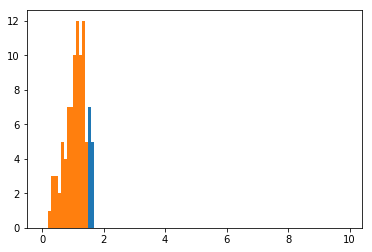

In [15]:
# Plot the distribution of the angles 
tmp=plt.hist(angles, bins=np.arange(0,10,0.1))
tmp=plt.hist(angles[indiceesWithinFoV], bins=np.arange(0,10,0.1))


# Want to examine the sensitivity on "MarginForErrorRadians"
 - I.e., how wide is wide enough (so that we don't keep calculating orbits for no reason) ?

In [16]:
# Start by making a compact version of the analysis performed in the above cells...
def evaluate_pointing( P, deg , DEBUG=False):
    # Calculate the approximate HP list with the margin-for-error
    P.HP_covered_by_FoV(MarginForErrorRadians=np.radians(deg))
    
    # Import the Object List for the pointing ...
    obsCode = '500'
    JDUTCstr = str(int(P.JDutc))+"_5"
    OrbitObjectList = mpchecker.OrbitObjectsByHP(P.HPfov , JDUTCstr , obsCode)
    
    # Optionally get the location of the objects at the mid-night time
    if DEBUG:
        RAmid_,DECmid_=[],[]
        for OO in OrbitObjectList:
            JDmid = int(P.JDutc) + 0.5
            helio_eq_posn = MPCL.Observatory().getObservatoryPosition(obsCode, JDmid)
            helio_ec_posn = np.dot(np.transpose(PHYS.rot_mat), helio_eq_posn )
            r, d = OO.get_RADEC( np.array([JDmid]), helio_ec_posn)
            RAmid_.append(r[0]), DECmid_.append(d[0])
            
        anglesMid = calc_angles_wrt_center_radec = P.calc_angles_wrt_center_radec(RAmid_, DECmid_)

    
    # Propagate orbits to time of pointing
    RA_,DEC_=[],[]
    for OO in OrbitObjectList:
        r, d = OO.get_RADEC( np.array([P.JDutc]), P.helio_ec_posn)
        RA_.append(r[0]), DEC_.append(d[0])
        
    # This step not needed ... 
    if DEBUG:
        angles = calc_angles_wrt_center_radec = P.calc_angles_wrt_center_radec(RA_, DEC_)


    # Get the indicees of the objects which fall within the FoV
    indiceesWithinFoV = P.select_RADEC_within_FoV(RA_, DEC_)

    
    if DEBUG:
        print("\n Deg = ", deg)
        print("Number of HP touched by FOV:" , len(P.HPfov))
        print("Number of Candidate objects:" , len(OrbitObjectList))
        print("Number of angles @ middle-of night:" , len(anglesMid))
        print("\t Min/Mean/Max of angles = ", np.min(anglesMid), np.mean(anglesMid), np.max(anglesMid))
        print("Number of angles @ pointing-times:" , len(angles))
        print("\t Min/Mean/Max of angles = ", np.min(angles), np.mean(angles), np.max(angles))
        print("Number of angles withion FoV:" , len(angles[indiceesWithinFoV]))
        print("\t Min/Mean/Max of angles = ", np.min(angles[indiceesWithinFoV]), np.mean(angles[indiceesWithinFoV]), np.max(angles[indiceesWithinFoV]))
    
    # Return the number of indicees within the FoV 
    if DEBUG:
        return len(OrbitObjectList), len(indiceesWithinFoV[0]), len(P.HPfov), RA_,DEC_
    else:
        return len(OrbitObjectList), len(indiceesWithinFoV[0]), len(P.HPfov)
        

In [20]:
%%time
# Look at some different values of the "MarginForErrorRadians"
# - N.B. I am just printing out the total number of returned objects within the FoV
c = ['k', 'r', 'b', 'y', 'darkgreen', 'orange']
for i, deg in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]):
    nTot_, nIn_, nHP_ = [],[],[]
    nPeval = 200
    for P in PointingList[:nPeval] :  ## <<-- To save time, just doing a subset of the pointings
        _ = evaluate_pointing( P, deg, DEBUG=False)
        nTot_.append(_[0])
        nIn_.append(_[1])
        nHP_.append(_[2])
    print("Margin: ",deg , " , Ncandidates=", np.sum(nTot_), " N_in_Fov=", np.sum(nIn_), " Mean_HPfov=", np.mean(nHP_))
    #print("angles   [:5] = ", _[2][:5])
    #print("anglesMid[:5] = ", _[4][:5])
    #plt.plot(_[2], _[3], 'o')
    #tmp=plt.hist(_[2],       bins=np.arange(0,10,0.1), color=c[i], alpha=0.01, edgecolor='k')
    #tmp=plt.hist(_[2][_[3]], bins=np.arange(0,10,0.1), color=c[i], alpha=0.25)
#plt.plot(P.RADEC[0], P.RADEC[1], '*', markersize=20)

Margin:  0.0  , Ncandidates= 21587  N_in_Fov= 17387  Mean_HPfov= 167.655
Margin:  0.1  , Ncandidates= 24166  N_in_Fov= 17402  Mean_HPfov= 187.87
Margin:  0.2  , Ncandidates= 26892  N_in_Fov= 17404  Mean_HPfov= 209.785
Margin:  0.3  , Ncandidates= 29863  N_in_Fov= 17404  Mean_HPfov= 233.075
Margin:  0.4  , Ncandidates= 32912  N_in_Fov= 17404  Mean_HPfov= 256.8
Margin:  0.5  , Ncandidates= 36250  N_in_Fov= 17404  Mean_HPfov= 283.045
Margin:  0.6  , Ncandidates= 39464  N_in_Fov= 17404  Mean_HPfov= 308.655
CPU times: user 5.38 s, sys: 65.5 ms, total: 5.44 s
Wall time: 5.41 s


# The above results asymptote for MarginForErrorRadians ~ np.radians(0.4)
 - I think this is because MBAs @ 2AU move around 0.3 deg/day
 - N.B. the selected HP-scale is ~0.23 deg per side (i.e. ~0.11deg radius), so it seems likely that the asymptote@~0.4deg is NOT being set by the HP-scale

# Testing "OrbitObjectsInPointing"
 - A general function to perform the above methods of finding all objects within a FoV 

In [18]:
%%time
OrbitObjectList = mpchecker.OrbitObjectsInPointing( PointingList[0] , '500' )
print(len(OrbitObjectList))

81
CPU times: user 4.66 ms, sys: 912 µs, total: 5.57 ms
Wall time: 4.75 ms
